In [1]:
import os
import yaml

from absl import logging
import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
import ddsp.colab.colab_utils
from ddsp.spectral_ops import compute_mel, compute_logmel
import ddsp.training
import gin
import gin.tf
import gin.tf.external_configurables

import wandb
resume = False
wandb_id = 'placeholder'
logging.set_verbosity(logging.INFO)

gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

/home/samuel/Development/venv3/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


tensorflow.python.keras.regularizers.L1

In [2]:
wandb_id = '3cyfilm7'
models_dir = './wandb_models'
# wandb.init(project="asmr-impact", resume=resume, id=wandb_id)
# wandb_id = wandb.run.id
save_dir = os.path.join('./wandb', wandb_id)
conf = wandb.config
print(wandb_id)

3cyfilm7


In [3]:
example_secs = 0.5
offset_secs = 1.17
gin.parse_config_file(ddsp.training.train_util.get_latest_operative_config(save_dir))
train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

-4
4.0
/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-*.wav


In [4]:
model = ddsp.training.models.get_model()

Z time steps: 126


In [5]:
model.restore(save_dir)

INFO:absl:Loaded checkpoint ./wandb/3cyfilm7/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


In [6]:
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')
decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
print(decoded_audio.shape)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
IPython.display.Audio(data=decoded_audio, rate=int(audio_sample_rate))

(1, 22050)


In [7]:
for k in prediction:
    print(k)
print(prediction['reverb_decay'])
print(prediction['reverb_gain'])

NameError: name 'prediction' is not defined

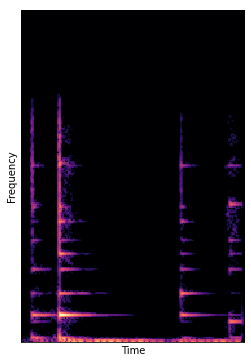

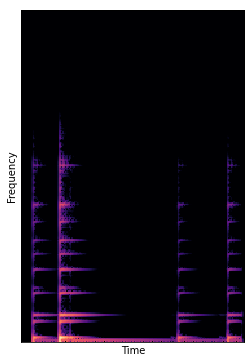

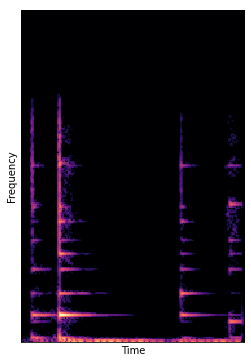

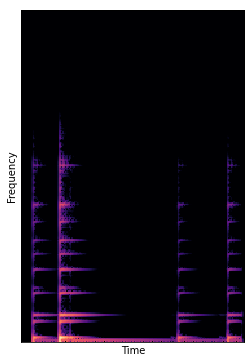

In [8]:
prediction = model(next(iter(test_input)), training=False)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()
IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

In [9]:
print(prediction['impact']['signal'])

tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 44100), dtype=float32)


In [65]:
fig_width = 6
fig_height = 4
def plot_spec(audio, size, vmin=-5,
             vmax=1,
             rotate=True, **matshow_kwargs):
    if len(audio.shape) == 2:
        audio = audio[0]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    print(np.max(logmag))
    f, t, Zxx = scipy.signal.stft(audio, train_sample_rate, nperseg=size, noverlap=int(0.75*size))
    # logmag = spectral_ops.compute_logmel(core.tf_float32(audio), lo_hz=8.0, bins=80, fft_size=size)
    # logmag = spectral_ops.compute_mfcc(core.tf_float32(audio), mfcc_bins=40, fft_size=size)
    if rotate:
        # logmag = np.rot90(np.log(np.abs(Zxx)))
        logmag = np.rot90(logmag)
    # Plotting.
    logmag = logmag[60:, :]
    plt.matshow(logmag,
              vmin=vmin,
              vmax=vmax,
              cmap=plt.cm.magma,
              aspect='auto',
              **matshow_kwargs)
    
    print(f.shape)
    
    skip_num = 20
    print(logmag.shape)
    plt.yticks(ticks=list((range(logmag.shape[0], 0, -skip_num))).reverse())
    tick_locs = np.arange(logmag.shape[0]-1, 0, -skip_num)
    ticks = np.arange(0, logmag.shape[0]-1, skip_num)
    print(ticks)
    print(f[ticks])
    t = np.arange(test_samples) / train_sample_rate
    plt.yticks(tick_locs, f[ticks].astype(np.int32))
    xtick_nums = np.arange(0, example_secs, 0.1)
    # xtick_locs = np.arange(0, logmag.shape[1], int(skip_num*1.5))
    xtick_locs = (xtick_nums / example_secs * logmag.shape[1]).astype(np.int32)
    xtick_nums = xtick_locs / logmag.shape[1] * example_secs
    plt.xticks(xtick_locs, ['%0.2f'%d for d in xtick_nums])
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # plt.yticks([])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

1.0076295
(257,)
(197, 173)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


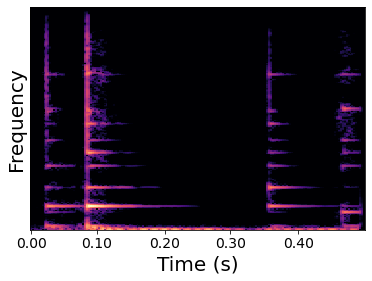

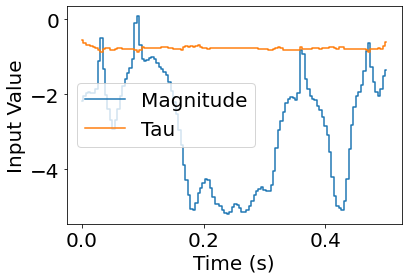

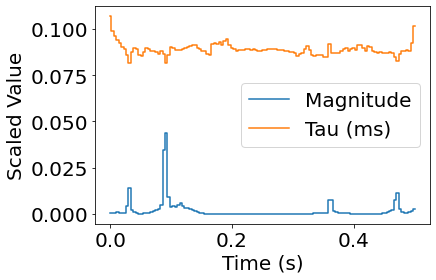

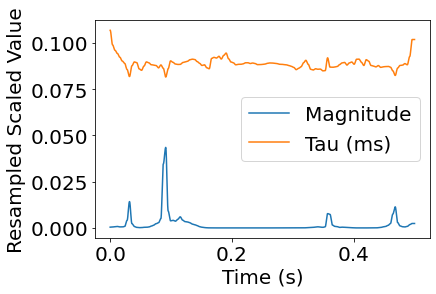

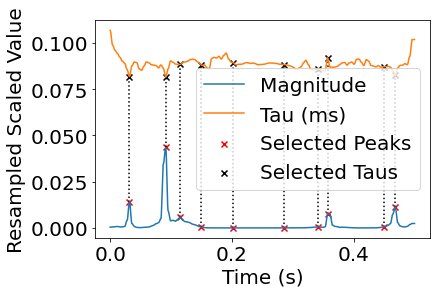

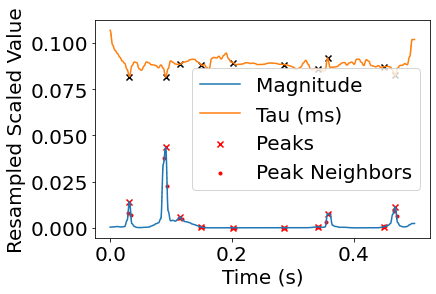

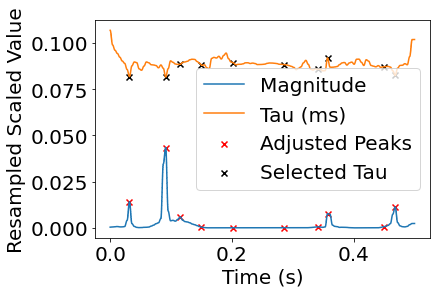

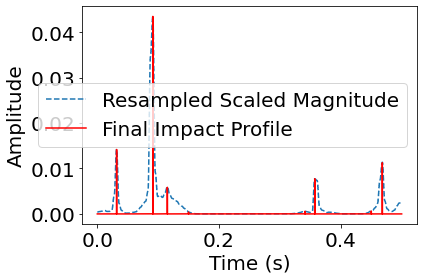

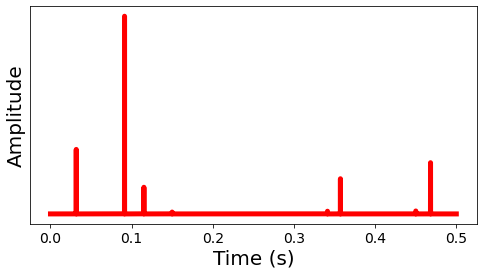

0.7369376
(257,)
(197, 173)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


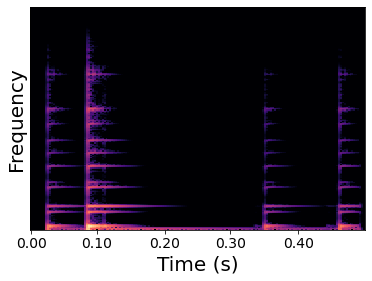

In [66]:
no_axis = True
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
font_size = 20
plt.rcParams['font.size'] = font_size

output_dir = '/home/samuel/Downloads/impact_profile_noaxis'
plot_spec(prediction['audio'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
    plt.ylabel('Frequency')
    
fig.savefig(os.path.join(output_dir, 'original_spec.png'), bbox_inches='tight')
plt.show()

logit_length = np.squeeze(prediction['magnitudes']).shape[0]
t_logit = np.linspace(0, test_samples/train_sample_rate, logit_length)
plt.plot(t_logit, np.squeeze(prediction['magnitudes']), drawstyle='steps-mid')
plt.plot(t_logit, np.squeeze(prediction['taus']), drawstyle='steps-mid')
plt.legend(('Magnitude', 'Tau'))
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, 'logits.png'), bbox_inches='tight')
plt.show()

plt.plot(t_logit, np.squeeze(prediction['impact']['controls']['magnitudes']), drawstyle='steps-mid')
plt.plot(t_logit, 1000 * np.squeeze(prediction['impact']['controls']['taus']), drawstyle='steps-mid')
plt.legend(('Magnitude', 'Tau (ms)'))
plt.xlabel('Time (s)')
plt.ylabel('Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, 'scaled_logits.png'), bbox_inches='tight')
plt.show()

t = np.linspace(0, test_samples/train_sample_rate, test_samples)
magnitude_envelopes = ddsp.core.resample(prediction['impact']['controls']['magnitudes'], test_samples,
                                        method='window')
taus = ddsp.core.resample(prediction['impact']['controls']['taus'], test_samples,
                                        method='window')
plt.plot(t, np.squeeze(magnitude_envelopes))
plt.plot(t, 1000 * np.squeeze(taus))
plt.legend(('Magnitude', 'Tau (ms)'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, 'resampled_logits.png'), bbox_inches='tight')
plt.show()

window_size = int(train_sample_rate / 20)
magnitude_envelopes = tf.expand_dims(magnitude_envelopes, axis=1)
weight_distance = 100
vals, inds = tf.nn.max_pool_with_argmax(magnitude_envelopes, window_size, window_size, 'SAME')
plt.plot(t, np.squeeze(magnitude_envelopes))
plt.plot(t, 1000 * np.squeeze(taus))
plt.scatter(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.vlines(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], colors='black', linestyles='dotted')
plt.legend(('Magnitude', 'Tau (ms)', 'Selected Peaks', 'Selected Taus'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.savefig(os.path.join(output_dir, 'peak_selection.png'), bbox_inches='tight')
fig.set_size_inches(fig_width, fig_height)
plt.show()

# Use a weighted average of magnitude to select peak time so that things can shift around
augmented_inds = tf.concat([inds - weight_distance, inds, inds + weight_distance], axis=-1)
b,w,h,c = magnitude_envelopes.get_shape().as_list()
mags_pooled = tf.gather(tf.reshape(magnitude_envelopes, shape=[b*w*h*c]), augmented_inds)
plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid')
plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
plt.scatter(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds-weight_distance)], np.squeeze(magnitude_envelopes)[np.squeeze(inds-weight_distance)], marker='.', c='red')
plt.scatter(t[np.squeeze(inds+weight_distance)], np.squeeze(magnitude_envelopes)[np.squeeze(inds+weight_distance)], marker='.', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.legend(('Magnitude', 'Tau (ms)', 'Peaks', 'Peak Neighbors'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, 'peak_adjustment.png'), bbox_inches='tight')
plt.show()

weighted_inds = tf.reduce_sum(tf.cast(augmented_inds, dtype=tf.float32) * mags_pooled, axis=-1) / tf.reduce_sum(mags_pooled, axis=-1)
peak_times = tf.cast(weighted_inds / train_sample_rate, dtype=tf.float32)
plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid')
plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
plt.scatter(peak_times, np.squeeze(magnitude_envelopes)[np.squeeze(weighted_inds).astype(np.int32)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.legend(('Magnitude', 'Tau (ms)', 'Adjusted Peaks', 'Selected Tau'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, 'adjusted_peaks.png'), bbox_inches='tight')
plt.show()

plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid', linestyle='dashed')
# plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
# plt.scatter(peak_times, np.squeeze(magnitude_envelopes)[np.squeeze(weighted_inds).astype(np.int32)], marker='x', c='red')
# plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(('Resampled Scaled Magnitude','Final Impact Profile'))
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, 'impact_signal.png'), bbox_inches='tight')
plt.show()

t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red', linewidth=5)

plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
   
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
fig.savefig(os.path.join(output_dir, 'impact_signal_only.png'), bbox_inches='tight')
plt.show()

plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, 'synth_spec.png'), bbox_inches='tight')
plt.show()

(176400,)


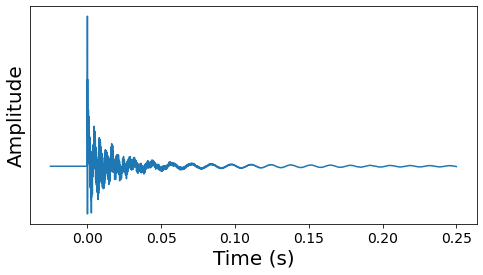

In [28]:
output_dir = '/home/samuel/Downloads/modal_fir'
begin_offset = int(train_sample_rate * 1.95)
cutoff = int(train_sample_rate * 2.5)

ir = np.squeeze(prediction['modal_fir']['signal'])
print(ir.shape)
ir = ir[begin_offset:cutoff]
t2 = (np.arange(0, ir.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
plt.plot(t2, ir)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, 'ir.png'), bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/samuel/Downloads/filtered_noise/ir.png'

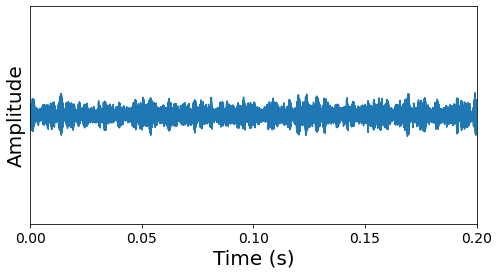

In [36]:
output_dir = '/home/samuel/Downloads/filtered_noise'

noise = np.squeeze(prediction['filtered_noise']['signal'])
t2 = np.arange(0, 2 * train_sample_rate * example_secs) / (2 * train_sample_rate)
plt.plot(t2, noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim((-0.0002, 0.0002))
plt.xlim((0, 0.2))
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, 'ir.png'), bbox_inches='tight')
plt.show()

(48882,)


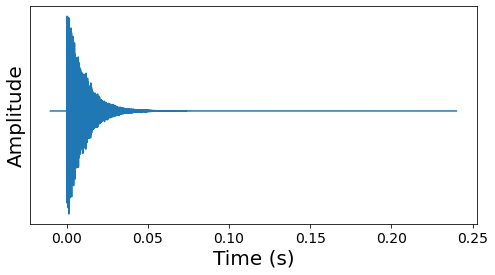

In [58]:
output_dir = '/home/samuel/Downloads/modal_fir'
begin_offset = int(train_sample_rate * 0.02)
cutoff = int(train_sample_rate * 0.5)

ir = np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))
print(ir.shape)
ir = ir[:cutoff]
t2 = (np.arange(0, ir.shape[0])  - begin_offset) / (2 * train_sample_rate)
plt.plot(t2, ir)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, 'room_ir.png'), bbox_inches='tight')
plt.show()

0.7369376
(257,)
(197, 173)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


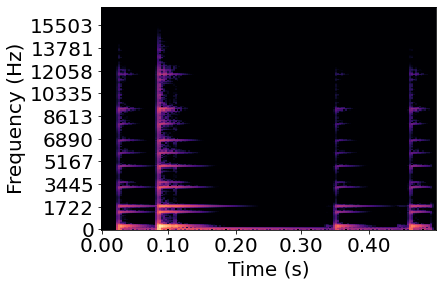

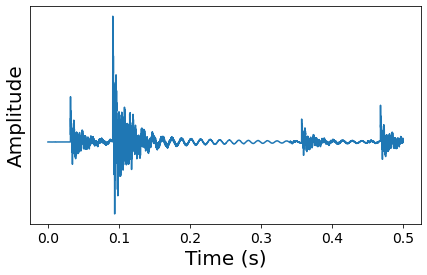

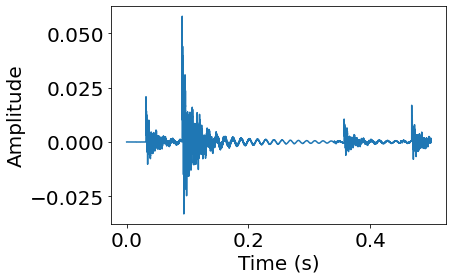

In [59]:
output_dir = '/home/samuel/Downloads/final_audio'
plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
fig.savefig(os.path.join(output_dir, 'synth_spec.png'), bbox_inches='tight')
plt.show()
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+1, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, 'waveform.png'), bbox_inches='tight')
plt.show()
plt.rcParams.update({
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.2),
})
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, 'waveform_translucent.png'), bbox_inches='tight')
plt.show()

In [ ]:
    for i in range(5):
    filename = 'XogoXRu8jvY-05-00%i0.wav'%i
    original_name = os.path.join('/data/datasets/asmr/tapping/valid/', filename)
    synth_name = os.path.join('examples/dubbing05-05-21/proposed', filename)
    audio = tf.io.read_file(original_name)
    decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[:test_samples]), axis=0)
    test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
    prediction = model(next(iter(test_input)), training=False)
    audio_synth = prediction['audio_synth'][:1, :]
    scipy.io.wavfile.write(synth_name, int(audio_sample_rate), np.array(32767 * audio_synth[0, :] / np.max(np.abs(audio_synth))).astype(np.int16))

In [ ]:
# print(prediction['modal_fir']['controls']['frequencies'])
# if False:
modal_model = np.zeros((len(np.squeeze(prediction['modal_fir']['controls']['frequencies'])), 3), dtype=np.float32)
modal_model[:, 0] = np.squeeze(prediction['modal_fir']['controls']['frequencies'])
modal_model[:, 1] = np.squeeze(prediction['modal_fir']['controls']['gains'])
modal_model[:, 2] = np.squeeze(prediction['modal_fir']['controls']['dampings'])
np.save('modal_model.npy', modal_model)

In [ ]:
time_begin = 1
example_secs = 1
gin.parse_config_file(ddsp.training.train_util.get_latest_operative_config(save_dir))
train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
model = ddsp.training.models.get_model()
model.restore(save_dir)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
prediction = model(next(iter(test_input)), training=False)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)

# 